# Maskinlæring

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Lese dataene
titanic = pd.read_csv("Datafiler/titanic.csv")

### Utforsking og opprydding av datasettet
La oss undersøke dataene og rydde litt, dersom vi trenger det.

In [6]:
# Skriver ut fem første linjer
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,deck,embark_town,alive,alone
0,0,3,0,22.0,1,0,7.2500,S,Third,NaN,Southampton,no,False
1,1,1,1,38.0,1,0,71.2833,C,First,C,Cherbourg,yes,False
2,1,3,1,26.0,0,0,7.9250,S,Third,NaN,Southampton,yes,True
3,1,1,1,35.0,1,0,53.1000,S,First,C,Southampton,yes,False
4,0,3,0,35.0,0,0,8.0500,S,Third,NaN,Southampton,no,True


Vi ser at det ikke er alle kategoriene vi trenger. Siden vi er interessert i hvem som overlevde, og hvorfor, kan det også være lurt å sjekke hvor mange dette var.

In [7]:
# Hvor mange overlevde?
overlevde_prosent = (titanic['survived'].sum()/titanic['survived'].count())*100
print(f'{overlevde_prosent:.2f} % overlevde')

38.38 % overlevde


In [8]:
# Sletter kategorier vi ikke er interessert i
titanic.pop('deck')
titanic.pop('fare')
titanic.pop('embarked')
titanic.pop('embark_town')

0      Southampton
1        Cherbourg
2      Southampton
3      Southampton
4      Southampton
          ...     
886    Southampton
887    Southampton
888    Southampton
889      Cherbourg
890     Queenstown
Name: embark_town, Length: 891, dtype: object

In [9]:
# Print antall manglende verdier i kolonnene
print(titanic.isna().sum())

survived      0
pclass        0
sex           0
age         177
sibsp         0
parch         0
class         0
alive         0
alone         0
dtype: int64


In [10]:
# Fyller inn manglende alder med gjennomsnittet
gjennomsnitt = titanic['age'].mean()
titanic['age'].fillna(gjennomsnitt, inplace = True)

## Visualiseringer
La oss først se hvilken effekt klasse og kjønn hadde på overlevelsessjansene:

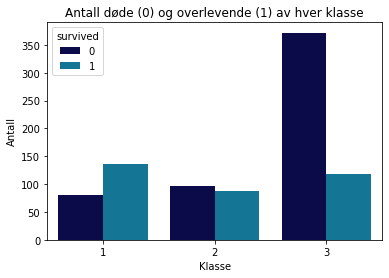

In [11]:
# Passasjerklasse
sns.countplot(x='pclass', hue='survived', data=titanic, palette='ocean')
plt.title("Antall døde (0) og overlevende (1) av hver klasse")
plt.xlabel("Klasse")
plt.ylabel("Antall")
plt.show()

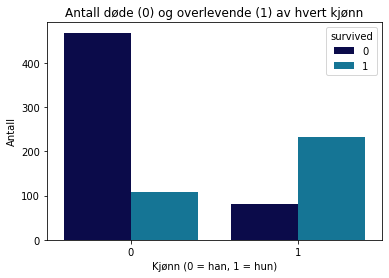

In [12]:
# Passasjerklasse
sns.countplot(x='sex', hue='survived', data=titanic, palette='ocean')
plt.title("Antall døde (0) og overlevende (1) av hvert kjønn")
plt.xlabel("Kjønn (0 = han, 1 = hun)")
plt.ylabel("Antall")
plt.show()

Vi ser, ikke overraskene at menn på 3. klasse hadde særdeles dårlige odds. Vi har alderen til passasjerene, men ikke 

<AxesSubplot:xlabel='aldersklasse', ylabel='count'>

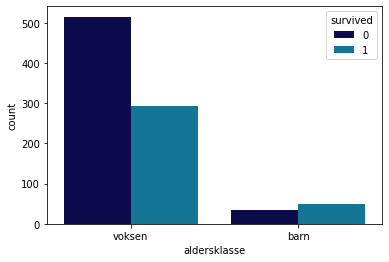

In [13]:
# Sortere etter alder
aldersklasse = []

for alder in titanic['age']:
    if alder > 15:
        aldersklasse.append("voksen")
    else:
        aldersklasse.append("barn")
        
titanic['aldersklasse'] = aldersklasse

sns.countplot(x='aldersklasse', hue='survived', data=titanic, palette='ocean')

In [14]:
# *Frivilling: Erstatte kategorier for visualisering med nye kategorier
"""
overlevende = {0: "døde", 1: "overlevde"}
titanic["survived"] = titanic["survived"].map(overlevende)
titanic.head(5)
"""
# *Frivillig: Telle forekomster av ulike tilfeller
"""
titanic["survived"].count()
titanic["survived"].value_counts()
"""
None # Printer None for å unngå output

## Maskinlæring
Vi skal nå lage en modell som kan forutsi hvorvidt en person overlever på Titanic eller ikke, gitt data om personen. Vi velger ut hvilke data vi ønsker å bruke som kriterium for overlevelse, og spesifiserer kategorien "survived" som målkategorien vår:

In [15]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import tree
from sklearn.metrics import accuracy_score, confusion_matrix

In [16]:
kriterier = titanic[['pclass', 'sex', 'age', 'sibsp', 'parch']]
kategorier = titanic['survived'] 

I maskinlæring er det viktig at modellen vår klarer å forutsi data som kommer utenfra datasettet vi trener modellen med. Derfor deler vi ofte opp dataene i et treningssett og et testsett. Treningssettet bruker vi til å trene modellen, testsettet til å teste og evaluere modellen i etterkant. Vi blander ikke disse dataene. Vi kan generere slike data med funksjonen _train\_test\_split()_. Her bruker vi 80 \% av dataene til trening og 20 \% til testing. Du bør bruke minst 70 \% av dataene dine til trening.

In [17]:
testandel = 0.2 # Andel brukt til testing
ml_data = train_test_split(kriterier, kategorier, test_size=testandel, random_state=42)

treningskriterier = ml_data[0]
testkriterier = ml_data[1]
treningskategorier = ml_data[2]
testkategorier = ml_data[3]

Nå kan vi lage modellen vår. Vi bruker en algoritme som heter _Decision Tree Classifier_. Det er basert på sammensatte og forgreinede valgtrær, der alle kombinasjoner av kriterier blir utforsket. Betingede sannsynligheter for ulike hendelser blir beregnet, og de mest sannsynlige utfallene blir framhevet basert på kombinasjonen av kriteriene. Først trener vi modellen:

In [18]:
modell = tree.DecisionTreeClassifier()
modell.fit(treningskriterier, treningskategorier)

DecisionTreeClassifier()

Det var det - da har vi en modell! Den ligger nå i et objekt som vi har kalt _modell_. Vi kan få innsyn i hvordan modellen ser ut, men det kan fort bli litt uoversiktlig og teknisk. La oss først nøye oss med å sjekke hvordan modellen takler testsettet vårt.

## Test og validering av modellen

In [19]:
modellkategorier_forutsett = modell.predict(testkriterier)
accuracy_score(testkategorier, modellkategorier_forutsett)

0.7653631284916201

Dette betyr at modellen forutsier riktig ca. 76 % av gangene. Det er en ok modell. For å få bedre oversikt over hva modellen forutsier riktig og hva den feiler på, kan vi konstruere en såkalt "Confusion Matrix" (forvirringsmatrise/feilmatrise):

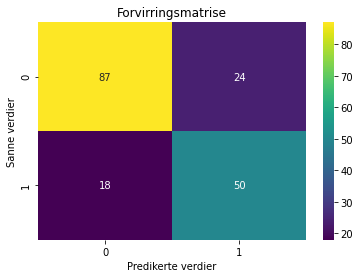

In [20]:
cm = confusion_matrix(modellkategorier_forutsett, testkategorier)

import seaborn as sns
sns.heatmap(cm, annot=True, cmap='viridis')
plt.title("Forvirringsmatrise")
plt.xlabel("Predikerte verdier")
plt.ylabel("Sanne verdier")
plt.show()

La oss benytte disse dataene og telle hvor mange datapunkter vi har, hvor mange som overlevde og døde, og deretter beregne hvor stor prosentandel av overlevende og døde som modellen klarte å forutsi korrekt.

In [21]:
presisjon_død = (87/(87+25))*100
presisjon_overleve = (49/(49+18))*100
print(f'(Andel korrekt forventet død {presisjon_død:.2f} %)')
print(f'(Andel korrekt forventet overlevelse {presisjon_overleve:.2f} %)')

(Andel korrekt forventet død 77.68 %)
(Andel korrekt forventet overlevelse 73.13 %)


Det er større presisjon i å forutsi død. Dette er forventet, siden modellen har trent på flere tilfeller av død enn av overlevelse. 

La oss helt til sist visualisere modellen vår. Vi velger maks dybde på modellen til 3 for at vi ikke skal få alt for mange forgreininger.

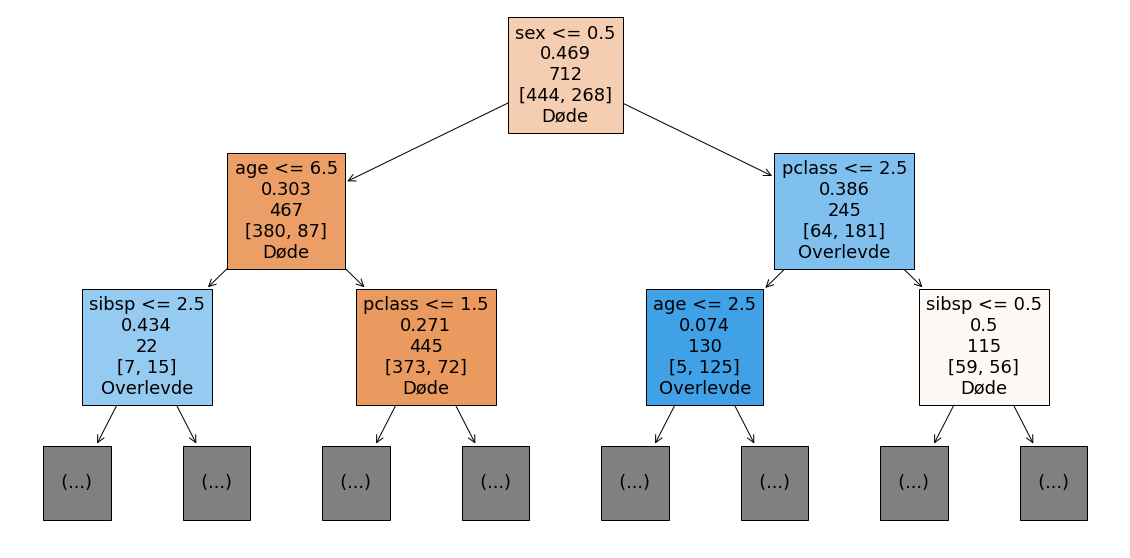

In [22]:
plt.figure(figsize=(20,10))
titanic.pop('survived')
tree.plot_tree(modell, max_depth=2, feature_names=titanic.columns, class_names=['Døde', 'Overlevde'], filled=True, label=None,) 
None